## Model Selection and Training on Train Data

### Importing Required Libraries

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install shap

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import shap

#### Importing Processed train data

In [71]:
#importing processed train data
traindata = pd.read_csv('/content/traindata_processed.xls')
pd.set_option('display.max_columns', None)
traindata.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Time,Weekday,Hour
0,1709396985476,26,18583,687462,31,813,12,0,9,1,360606,160396,453297,153085,529644,1631,860,3421,881,4132.0,3586.0,66.0,10630.0,6,2024,21406,3,5
1,927712939180,33,5065,3990,38,25,9,0,17,0,360606,160396,453297,3142,529644,1631,860,3421,881,289573.0,3586.0,66.0,10630.0,3,2024,38708,0,10
2,1090921697002,201,150787,807590,419,444,6,0,17,0,360606,160396,453297,4181,529644,1631,860,3421,881,289573.0,3586.0,66.0,10630.0,13,2024,13000,3,3
3,1434519079555,204,108287,28575,44,1233,16,2,9,1,360606,160396,453297,153085,529644,1631,860,3421,881,97007.0,3586.0,66.0,10630.0,8,2024,60896,5,16
4,1005022347708,54,528202,1458226,102,58829,7,0,9,0,360606,160396,453297,153085,529644,1631,860,3421,881,39978.0,3586.0,66.0,10630.0,9,2024,10081,6,2


In [72]:
traindata.shape

(3299972, 28)

In [73]:
traindata.isnull().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,0
EntityType,0
EvidenceRole,0


#### Defining features (X) and target (y)

In [74]:
x = traindata.drop(columns=['IncidentGrade','Id'])
y = traindata['IncidentGrade'] # Target column

In [75]:
# Stratified train-validation split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

In [76]:
# Checking class distribution in training and validation sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Validation set class distribution:\n", y_val.value_counts(normalize=True))

Training set class distribution:
 IncidentGrade
0    0.431802
2    0.351452
1    0.216746
Name: proportion, dtype: float64
Validation set class distribution:
 IncidentGrade
0    0.431802
2    0.351452
1    0.216745
Name: proportion, dtype: float64


## Model Selection and Training:

### Baseline Models

In [77]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2309980 entries, 1983754 to 206339
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   OrgId               int64  
 1   IncidentId          int64  
 2   AlertId             int64  
 3   DetectorId          int64  
 4   AlertTitle          int64  
 5   Category            int64  
 6   EntityType          int64  
 7   EvidenceRole        int64  
 8   IpAddress           int64  
 9   Url                 int64  
 10  AccountName         int64  
 11  DeviceName          int64  
 12  NetworkMessageId    int64  
 13  RegistryKey         int64  
 14  RegistryValueData   int64  
 15  ApplicationName     int64  
 16  OAuthApplicationId  int64  
 17  FileName            float64
 18  ResourceIdName      float64
 19  OSVersion           float64
 20  City                float64
 21  Day                 int64  
 22  Year                int64  
 23  Time                int64  
 24  Weekday             int6

In [78]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))



Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.60      0.48      0.54    427481
     Class 1       0.35      0.31      0.33    214576
     Class 2       0.52      0.69      0.59    347935

    accuracy                           0.52    989992
   macro avg       0.49      0.49      0.49    989992
weighted avg       0.52      0.52      0.51    989992


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99    427481
     Class 1       0.98      0.98      0.98    214576
     Class 2       0.99      0.99      0.99    347935

    accuracy                           0.99    989992
   macro avg       0.98      0.98      0.98    989992
weighted avg       0.99      0.99      0.99    989992



### Advanced Models

In [79]:
# Advanced models with optimized parameters for faster training
advanced_models = {
    'Random Forest': RandomForestClassifier(
        class_weight='balanced', random_state=42,
        n_estimators=100, max_depth=10, n_jobs=-1  # Reduced trees and limited depth
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42, n_estimators=50, max_depth=5  # Reduced estimators and depth
    )
}

# Add XGBoost
try:
    advanced_models['XGBoost'] = XGBClassifier(
        scale_pos_weight=1, random_state=42,
        tree_method='hist',  # Use 'hist' instead of 'gpu_hist' for faster execution
        predictor='auto',
        n_estimators=50, max_depth=6
    )
except ImportError:
    print("XGBoost not installed.")

# Add LightGBM
try:
    advanced_models['LightGBM'] = LGBMClassifier(
        class_weight='balanced', random_state=42,
        n_estimators=50, max_depth=6, num_leaves=20, n_jobs=-1  # Reduce estimators and leaf size
    )
except ImportError:
    print("LightGBM not installed.")

# Reduce dataset size for training (optional: take only 50% of the data)
x_train_sample = x_train.sample(frac=0.5, random_state=42)
y_train_sample = y_train.loc[x_train_sample.index]

# Training and evaluation for advanced models
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(x_train_sample, y_train_sample)  # Train on a smaller subset
    y_pred = model.predict(x_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))



Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.74      0.94      0.83    427481
     Class 1       0.81      0.72      0.76    214576
     Class 2       0.97      0.72      0.82    347935

    accuracy                           0.81    989992
   macro avg       0.84      0.79      0.80    989992
weighted avg       0.84      0.81      0.81    989992


Training Gradient Boosting...
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

     Class 0       0.76      0.96      0.85    427481
     Class 1       0.91      0.66      0.76    214576
     Class 2       0.93      0.80      0.86    347935

    accuracy                           0.84    989992
   macro avg       0.87      0.81      0.83    989992
weighted avg       0.86      0.84      0.84    989992


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:29:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.96      0.90    427481
     Class 1       0.93      0.78      0.85    214576
     Class 2       0.94      0.87      0.91    347935

    accuracy                           0.89    989992
   macro avg       0.91      0.87      0.89    989992
weighted avg       0.90      0.89      0.89    989992


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 1154990, number of used features: 26
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Classification Report:
               precision    recall  f1-score   support

     Class 0       0.82 

### Model Selection

### Baseline Models:

## Logistic Regression:
Moderate performance with an accuracy of 52%. Struggles with class imbalance, leading to a low macro-F1 score (0.49). Precision and recall vary, making it less effective for this problem.

## Decision Tree:
Achieves near-perfect accuracy (0.99), indicating strong performance but likely overfitting to the training data.

### Advanced Models:

#### Random Forest:
Performs well with 81% accuracy and balanced precision-recall across classes. However, Class 2 recall (0.72) is lower, indicating some misclassification.

#### Gradient Boosting:
Improves overall accuracy to 84% with better balance across classes. Class 1 recall (0.66) is lower, but F1-scores are strong.

#### XGBoost:
Achieves the highest accuracy (89%) with strong precision, recall, and F1-scores. Shows excellent class balance, making it the best performer.

#### LightGBM:
Performs well with 83% accuracy but struggles with Class 2 recall (0.78). Slightly weaker than XGBoost but still effective.

Based on these results, we proceed with XGBoost as the final model since it shows the best overall performance.

XGBoost achieves the highest macro F1-score (0.89) with balanced precision and recall. However, class imbalance is present, so we apply SMOTE.
Using only 20% of the training data for computational efficiency.

In [80]:
# Sample 20% of the training data
x_train_sample = x_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[x_train_sample.index]

In [82]:
# Check the sizes
print("Original Training Data Size:", x_train.shape)
print("Sampled Training Data Size:", x_train_sample.shape)

Original Training Data Size: (2309980, 26)
Sampled Training Data Size: (461996, 26)


### SMOTE

In [84]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_sample, y_train_sample)

In [85]:
# Checking the new class distribution
print("Original class distribution:\n", y_train_sample.value_counts())
print("After SMOTE class distribution:\n", y_train_smote.value_counts())

Original class distribution:
 IncidentGrade
0    198775
2    162931
1    100290
Name: count, dtype: int64
After SMOTE class distribution:
 IncidentGrade
0    198775
2    198775
1    198775
Name: count, dtype: int64


### Training XGB model on class balanced data

In [86]:
# Training the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb.fit(x_train_smote, y_train_smote)

# Prediction on the validation set
y_val_pred = xgb.predict(x_val)

# Evaluate performance
print("Validation Set Classification Report (After SMOTE):")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:32:45] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:32:45] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Validation Set Classification Report (After SMOTE):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    427481
     Class 1       0.85      0.89      0.87    214576
     Class 2       0.94      0.90      0.92    347935

    accuracy                           0.91    989992
   macro avg       0.90      0.91      0.90    989992
weighted avg       0.91      0.91      0.91    989992



### SHAP Analysis for Feature Importance

In [87]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_val)

<Figure size 640x480 with 0 Axes>

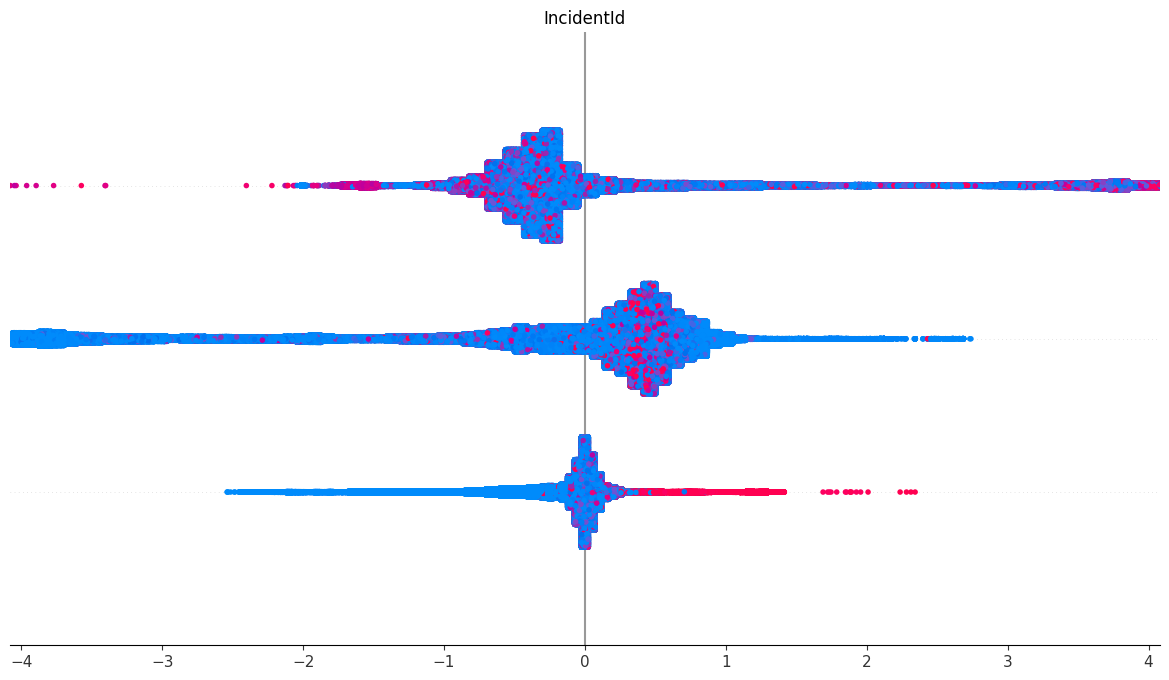

In [88]:
# Summary plot for feature importance
shap.summary_plot(shap_values, x_val, feature_names=x_val.columns)

In [89]:
# Defining top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId',
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']


In [90]:
# Filter datasets for top 11 features
x_train_top11 = x_train_smote[top_11_features]
x_val_top11 = x_val[top_11_features]

In [91]:
# Verify shapes
print("Shape of training set with top features:", x_train_top11.shape)
print("Shape of validation set with top features:", x_val_top11.shape)

Shape of training set with top features: (596325, 11)
Shape of validation set with top features: (989992, 11)


### Training XGB with only top 11 features

In [92]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(x_train_top11, y_train_smote)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(x_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:14] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    427481
     Class 1       0.84      0.90      0.87    214576
     Class 2       0.94      0.91      0.92    347935

    accuracy                           0.91    989992
   macro avg       0.90      0.91      0.91    989992
weighted avg       0.91      0.91      0.91    989992



## Hyperparameter Tuning

In [93]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search with GPU support
random_search_top11 = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        tree_method='hist',  # Enable GPU support
        device='cuda'  # Use GPU for predictions
    ),
    param_distributions=param_distributions,
    scoring='f1_macro',  # Scoring metric
    cv=3,
    n_iter=20,  # Number of random combinations
    verbose=1,
    n_jobs=-1  # Parallel processing
)

# Perform hyperparameter tuning
random_search_top11.fit(x_train_top11, y_train_smote)

# Get the best model
best_xgb_top11 = random_search_top11.best_estimator_
print("Best Parameters:", random_search_top11.best_params_)

# Evaluate on validation set
y_val_pred_best_top11 = best_xgb_top11.predict(x_val_top11)
print("Validation Set Classification Report (Tuned Top 11 Features):")
print(classification_report(y_val, y_val_pred_best_top11, target_names=['Class 0', 'Class 1', 'Class 2']))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:51:43] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:51:43] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:51:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Validation Set Classification Report (Tuned Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    427481
     Class 1       0.85      0.90      0.87    214576
     Class 2       0.95      0.91      0.93    347935

    accuracy                           0.91    989992
   macro avg       0.90      0.91      0.91    989992
weighted avg       0.91      0.91      0.91    989992



### The hyperparameter tuned model gives best scores. Saving the model.

In [94]:
import joblib

# Save the model
joblib.dump(best_xgb_top11, 'best_xgboost_Classification_model_SMOTE.pkl')
print("Model saved as best_xgboost_Classification_model_SMOTE.pkl")

Model saved as best_xgboost_Classification_model_SMOTE.pkl


## Final Evaluation on Test Set

In [96]:
# Loading test data
test_data = pd.read_csv('/content/testdata_processed.xls')
test_data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time,Weekday
0,1245540519230,657,11767,87199,524,563,11,0,27,0,360606,160396,863,153085,529644,1631,860,3421,881,289573,3586,66,10630.0,4,2024,22,82518,1
1,1400159342154,3,91158,632273,2,2,1,0,14,0,360606,160396,453297,2833,529644,1631,860,3421,881,289573,3586,0,10630.0,3,2024,12,46647,0
2,1279900255923,145,32247,131719,2932,10807,11,0,22,1,360606,160396,453297,153085,529644,1631,860,3421,881,14,3586,66,10630.0,8,2024,3,12037,5
3,60129547292,222,15294,917686,0,0,10,1,6,1,360606,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630.0,12,2024,12,43592,2
4,515396080539,363,7615,5944,27,18,5,0,27,0,360606,160396,136104,153085,529644,1631,860,3421,881,289573,3586,66,10630.0,6,2024,17,63663,3


In [97]:
# Selecting only top 11 features and setting features and target
x_test_top11 = test_data[top_11_features]
y_test = test_data['IncidentGrade']

In [98]:
# Predicting on the test set using the best model
y_test_pred_top11 = best_xgb_top11.predict(x_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.93      0.84      0.88   1357208
     Class 1       0.72      0.91      0.81    720247
     Class 2       0.94      0.89      0.92   1180244

    accuracy                           0.88   3257699
   macro avg       0.86      0.88      0.87   3257699
weighted avg       0.89      0.88      0.88   3257699



# Without Using Smote

In [100]:
# Train the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb.fit(x_train_sample, y_train_sample)

# Predict on the validation set
y_val_pred = xgb.predict(x_val)

# Evaluate performance
print("Validation Set Classification Report without smote:")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:53:28] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:53:28] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Validation Set Classification Report without smote:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92    427481
     Class 1       0.93      0.85      0.89    214576
     Class 2       0.94      0.91      0.93    347935

    accuracy                           0.92    989992
   macro avg       0.92      0.90      0.91    989992
weighted avg       0.92      0.92      0.92    989992



In [101]:
# Define top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId',
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']

# Filter datasets for top 11 features
x_train_sample_top11 = x_train_sample[top_11_features]
x_val_top11 = x_val[top_11_features]

# Verify shapes
print("Shape of training set with top features:", x_train_sample_top11.shape)
print("Shape of validation set with top features:", x_val_top11.shape)

Shape of training set with top features: (461996, 11)
Shape of validation set with top features: (989992, 11)


### Training XGB with only top 11 features on original dataset

In [102]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(x_train_sample_top11, y_train_sample)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(x_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:53:35] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:53:35] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.93    427481
     Class 1       0.93      0.85      0.89    214576
     Class 2       0.95      0.91      0.93    347935

    accuracy                           0.92    989992
   macro avg       0.92      0.91      0.92    989992
weighted avg       0.92      0.92      0.92    989992



### Hyperparameter Tuning

In [103]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search
random_search_top11 = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42,
                            tree_method='hist',  # Enable GPU support
                            device='cuda'  # Use GPU for predictions
                           ),
    param_distributions=param_distributions,
    scoring='f1_macro',
    cv=3,
    n_iter=20,  # Number of random combinations
    verbose=1,
    n_jobs=-1
)

# Perform hyperparameter tuning
random_search_top11.fit(x_train_sample_top11, y_train_sample)

# Get the best model
best_xgb_top11 = random_search_top11.best_estimator_
print("Best Parameters:", random_search_top11.best_params_)

# Evaluate on validation set
y_val_pred_best_top11 = best_xgb_top11.predict(x_val_top11)
print("Validation Set Classification Report (Tuned Top 11 Features):")
print(classification_report(y_val, y_val_pred_best_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:50] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:50] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 3, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Validation Set Classification Report (Tuned Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.93      0.96      0.95    427481
     Class 1       0.94      0.90      0.92    214576
     Class 2       0.96      0.94      0.95    347935

    accuracy                           0.94    989992
   macro avg       0.94      0.93      0.94    989992
weighted avg       0.94      0.94      0.94    989992



In [104]:
import joblib

# Save the model
joblib.dump(best_xgb_top11, 'best_XGB_Classification_model_without_SMOTE.pkl')
print("Model saved as best_XGB_Classification_model_without_SMOTE.pkl")

Model saved as best_XGB_Classification_model_without_SMOTE.pkl


## Final Evaluation on Test Set

In [105]:
# Predict on the test set
y_test_pred_top11 = best_xgb_top11.predict(x_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.91   1357208
     Class 1       0.89      0.86      0.87    720247
     Class 2       0.93      0.92      0.93   1180244

    accuracy                           0.91   3257699
   macro avg       0.91      0.90      0.91   3257699
weighted avg       0.91      0.91      0.91   3257699

